# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Import Libraries</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lightning --quiet

In [3]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", font_scale=1.5, font="SimHei", rc={"axes.unicode_minus":False})

import torch
import torchmetrics
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
pl.seed_everything(seed)

INFO: Seed set to 1


1

# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Read Dataset</div>

In [4]:
import os
dataset_labels = {'id': [], 'label': [], 'path': []}

for file in os.scandir('/kaggle/input/garbage-ver-2/frames/'):
    if file.is_dir():
        print(file.name)
        for folder in os.scandir(file.path):
            if folder.is_dir():
                for image in os.scandir(folder.path):
                    dataset_labels['id'].append(f'{folder.name}_{image.name[:-4]}')
                    dataset_labels['label'].append(file.name)
                    dataset_labels['path'].append(image.path)

df = pd.DataFrame(dataset_labels)
df.to_csv('data_meta.csv', index=False)

earth
bricks
tree
concrete


In [5]:
df.head()['path'][0]

'/kaggle/input/garbage-ver-2/frames/earth/M564KA716_01_11_2023 04_45_06/20.jpg'

In [6]:
from sklearn.model_selection import train_test_split

train_annot, test_annot = train_test_split(df, test_size=0.1, stratify=df['label'])

In [7]:
print(train_annot.shape)
print(test_annot.shape)

(30106, 3)
(3346, 3)


In [8]:
import os
import pandas as pd
from torchvision.io import read_image
annotations_file = pd.read_csv('/kaggle/working/data_meta.csv')
from torch.utils.data import Dataset

class GarbageDataset(Dataset):
    def __init__(self, annotations_file, transform=None, target_transform=None):
        class_to_index = {'bricks': 0,
                          'concrete': 1,
                          'earth': 2,
                          'tree': 3}
        self.img_labels = annotations_file
        self.transform = transform
        self.target_transform = target_transform
        self.classes = class_to_index.keys()
#         self.targets = torch.tensor([class_to_index[t] for t in self.img_labels['label']])

        self.targets = list(map(lambda x: class_to_index[x], self.img_labels['label']))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx]['path']
        image = read_image(img_path)
        label = self.img_labels.iloc[idx]['label']
        target = self.targets[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, target
    


In [25]:
from torchvision.transforms import v2

batch_size = 64

# train_transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])


train_transform = transforms.Compose([
                transforms.Resize((224, 224)),

                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                transforms.RandomRotation(degrees=30),
                transforms.ToTensor()
            ])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# test_transform = v2.Compose([
#     v2.ToPILImage(),
#     v2.Resize((224, 224)),
#     v2.ToDtype(torch.float32),
# ])

# train_transform = transforms.Compose([
#     v2.ToPILImage(),
#     v2.Resize((224, 224)),
#     v2.RandomHorizontalFlip(),
#     v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#     v2.RandomRotation(degrees=30),
#     v2.ToDtype(torch.float32),
# ])

# test_transform = A.Compose([
#     transforms.ToPILImage(),
#     A.Resize(256,256),
#     A.CenterCrop(224,224),
#     A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#     transforms.ToTensor()
# ])

# train_dataset = datasets.CIFAR10(root="./data", train=True, transform=train_transform, download=True)
# val_dataset = datasets.CIFAR10(root="./data", train=False, transform=test_transform, download=True)
train_dataset = GarbageDataset(train_annot, transform=train_transform)
val_dataset = GarbageDataset(test_annot, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = val_loader

# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Visualization</div>

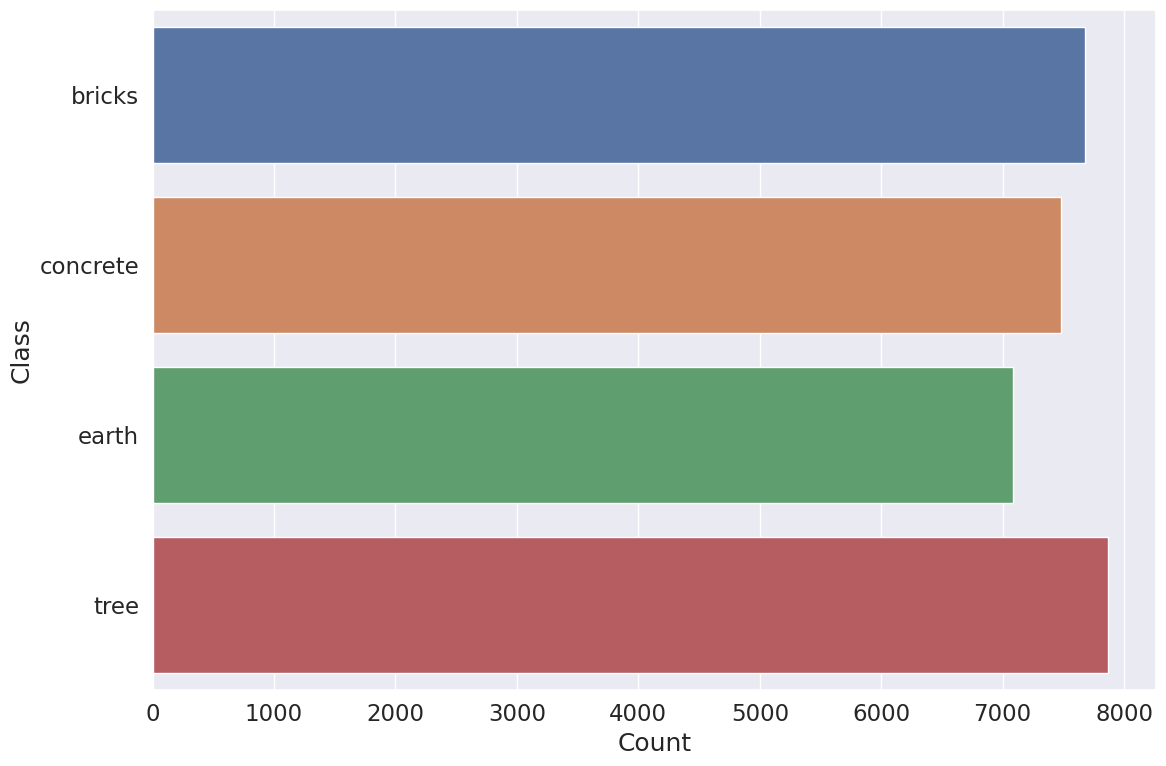

In [21]:
class_names = train_dataset.classes
class_count = [train_dataset.targets.count(i) for i in range(len(class_names))]
df = pd.DataFrame({"Class": class_names, "Count": class_count})

plt.figure(figsize=(12, 8), dpi=100)
sns.barplot(x="Count", y="Class", data=df)
plt.tight_layout()
plt.show()

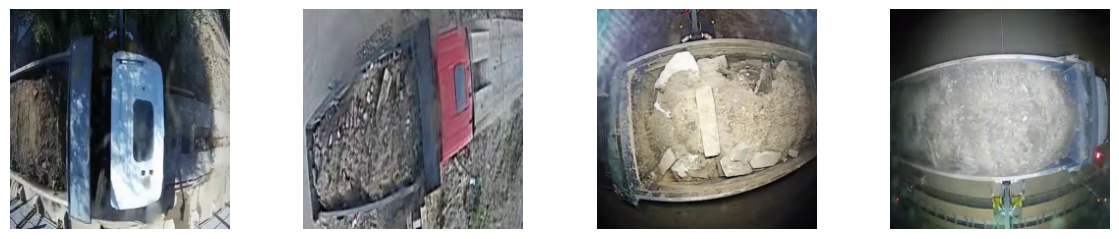

In [22]:
plt.figure(figsize=(12, 20), dpi=100)
images, labels = next(iter(val_loader))
for i in range(4):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(images[i].permute(1, 2, 0).numpy())
#     plt.title(class_names[labels[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()

# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Modeling</div>

In [23]:
from transformers import AutoImageProcessor, ConvNextV2ForImageClassification


class LitModel(pl.LightningModule):
    def __init__(self, num_classes=4):
        super().__init__()
        self.model = models.convnext_tiny(weights="IMAGENET1K_V1")
        self.model.classifier[2] = nn.Linear(768, num_classes)
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
    
    def forward(self, x):
        x = self.model(x)
        return x
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=0.001, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-5)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=False, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=False, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, logger=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        acc = self.accuracy(y_hat, y)
        self.log('test_acc', acc)
    
    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, y = batch
        y_hat = self(x)
        preds = torch.argmax(y_hat, dim=1)
        return preds

In [26]:
num_classes = 4
model = LitModel(num_classes=num_classes)
logger = CSVLogger("./")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=5, verbose=False, mode="min")
trainer = pl.Trainer(max_epochs=7, enable_progress_bar=True, logger=logger, callbacks=[early_stop_callback])
trainer.fit(model, train_loader, val_loader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type               | Params
------------------------------------------------
0 | model    | ConvNeXt           | 27.8 M
1 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
27.8 M    Trainable params
0         Non-trainable params
27.8 M    Total params
111.293   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
trainer.test(model, val_loader)

In [ ]:
trainer.save_checkpoint("best_model_2_aug.ckpt", weights_only=True)

# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Predict Test Data</div>

In [ ]:
pred = trainer.predict(model, test_loader)
pred = torch.cat(pred, dim=0)
pred = pd.DataFrame(pred.numpy(), columns=["Class"])
pred["Class"] = pred["Class"].apply(lambda x: class_names[x])

plt.figure(figsize=(12, 8), dpi=100)
sns.countplot(y="Class", data=pred)
plt.tight_layout()
plt.show()

# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Loss & Accuracy</div>

In [ ]:
log_path = logger.log_dir + "/metrics.csv"
metrics = pd.read_csv(log_path)

plt.figure(figsize=(12, 8), dpi=100)
sns.lineplot(x="epoch", y="train_loss", data=metrics, label="Train Loss", linewidth=2)
sns.lineplot(x="epoch", y="train_acc", data=metrics, label="Train Accuracy", linewidth=2)
sns.lineplot(x="epoch", y="val_loss", data=metrics, label="Valid Loss", linewidth=2)
sns.lineplot(x="epoch", y="val_acc", data=metrics, label="Valid Accuracy", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.tight_layout()
plt.show()